In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# loading data
df = pd.read_csv('/content/drive/MyDrive/kaiburr/complaints.csv')
df.shape

(4055791, 18)

In [4]:
df.head().T # Columns are shown in rows for easy reading

,0,1,2,3,4
Date received,2023-08-23,2023-08-23,2023-08-23,2023-08-23,2023-08-23
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Student loan,"Credit reporting, credit repair services, or o..."
Sub-product,Other personal consumer report,Credit reporting,Credit reporting,Federal student loan servicing,Credit reporting
Issue,Problem with a company's investigation into an...,Incorrect information on your report,Problem with a credit reporting company's inve...,Dealing with your lender or servicer,Problem with a credit reporting company's inve...
Sub-issue,Problem with personal statement of dispute,Information belongs to someone else,Their investigation did not fix an error on yo...,Received bad information about your loan,Investigation took more than 30 days
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,AMERICAN EXPRESS COMPANY,Experian Information Solutions Inc.,Experian Information Solutions Inc.,"Nelnet, Inc.",Experian Information Solutions Inc.
State,FL,PA,AL,GA,NC
ZIP code,33147,19061,35756,30009,283XX


In [5]:
df.tail().T # Columns are shown in rows for easy reading

,4055786,4055787,4055788,4055789,4055790
Date received,2015-02-21,2015-07-19,2022-06-16,2022-04-26,2022-08-15
Product,Credit card,Credit reporting,Mortgage,Debt collection,Checking or savings account
Sub-product,NaN,NaN,Conventional home mortgage,I do not know,Checking account
Issue,Sale of account,Incorrect information on credit report,Applying for a mortgage or refinancing an exis...,Attempts to collect debt not owed,Managing an account
Sub-issue,NaN,Account status,NaN,Debt is not yours,Deposits and withdrawals
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,JPMORGAN CHASE & CO.,"EQUIFAX, INC.",Mr. Cooper Group Inc.,V and H Portfolio,JPMORGAN CHASE & CO.
State,AL,IL,IA,SC,PA
ZIP code,36695,60614,52205,29624,17972


#Features in the dataset that weren't necessary for resolving our multi-classification problem are present.
**We are going to generate a new dataframe including the terms "product" and "consumer complaint narrative" (previously referred to as "consumer_complaint") for this text classification task.**

In [6]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(1469250, 2)

In [7]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

### There are over 3,62,000 complaints containing text out of almost a million total (36.2% of the original dataset is not null).
**Still, working with this number is a good idea. Let's now have a closer look at the categories into which we want to split up each complaint.**

In [8]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Student loan'],
       ['Credit reporting or other personal consumer reports'],
       ['Debt collection'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Payday loan, title loan, or personal loan'],
       ['Credit card'],
       ['Mortgage'],
       ['Money transfer, virtual currency, or money service'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Vehicle loan or lease'],
       ['Prepaid card'],
       ['Debt or credit management'],
       ['Payday loan'],
       ['Credit reporting'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

*There are 18 distinct classifications or groups (targets). It has been noted, though, that some classes are found in others. For instance, the category "credit card or prepaid card" includes the terms "credit card" and "prepaid card." Imagine that we are trying to categorize a brand-new credit card complaint. The system may correctly classify this complaint as either "credit card" or "credit card or prepaid." However, this would have an impact on the model's performance. Some categories have had their names changed in order to get around this issue.*



In [9]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [10]:
# Renaming categories
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [11]:
pd.DataFrame(df2.Product.unique())

,0
0,Credit card or prepaid card
1,"Credit reporting, repair, or other"
2,Mortgage
3,"Money transfer, virtual currency, or money ser..."
4,Debt collection
5,Vehicle loan or lease
6,Checking or savings account
7,"Payday loan, title loan, or personal loan"
8,Student loan
9,Bank account or service


* The number of classes were reduced from 18 to 13.

* Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [12]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
3111766,Credit card or prepaid card,I have asked Capital One to cancel a credit ca...,0
846149,"Credit reporting, repair, or other",In accordance with the Fair Credit Reporting a...,1
1435165,Mortgage,Foreclosed on by boa after loan modification w...,2
730567,"Money transfer, virtual currency, or money ser...","I have a personal account with wells fargo, an...",3
326119,Mortgage,This is an on coming issue with Wells Fargo ap...,2


---
* **Bar Plot:** Number of Complaints in Each Product Category
---

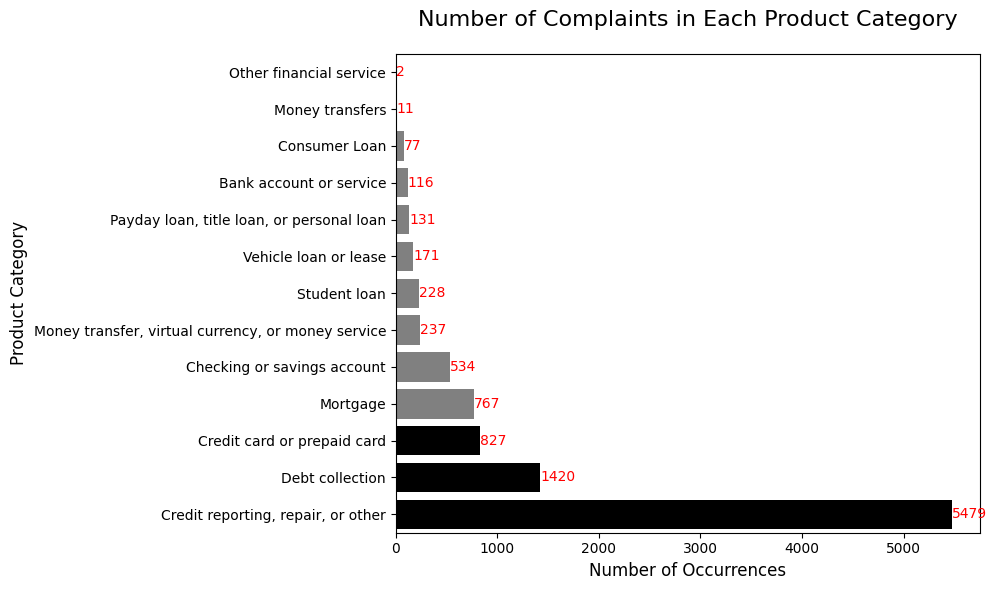

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Customizing the color palette
colors = ['gray'] * 10 + ['black'] * 3

# Group and sort the data
product_counts = df2.groupby('Product').Consumer_complaint.count().sort_values()

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a barplot using seaborn
sns.barplot(x=product_counts.values, y=product_counts.index, palette=colors)

# Adding a title and labels
plt.title('Number of Complaints in Each Product Category', fontsize=16, pad=20)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Product Category', fontsize=12)

# Customizing tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adding data labels on the bars
for i, v in enumerate(product_counts):
    plt.text(v + 0.3, i, str(v), color='red', va='center', fontsize=10)

plt.tight_layout()
plt.show()


---
* Pie Chart: You can create a pie chart to show the distribution of complaints across different product categories.
---

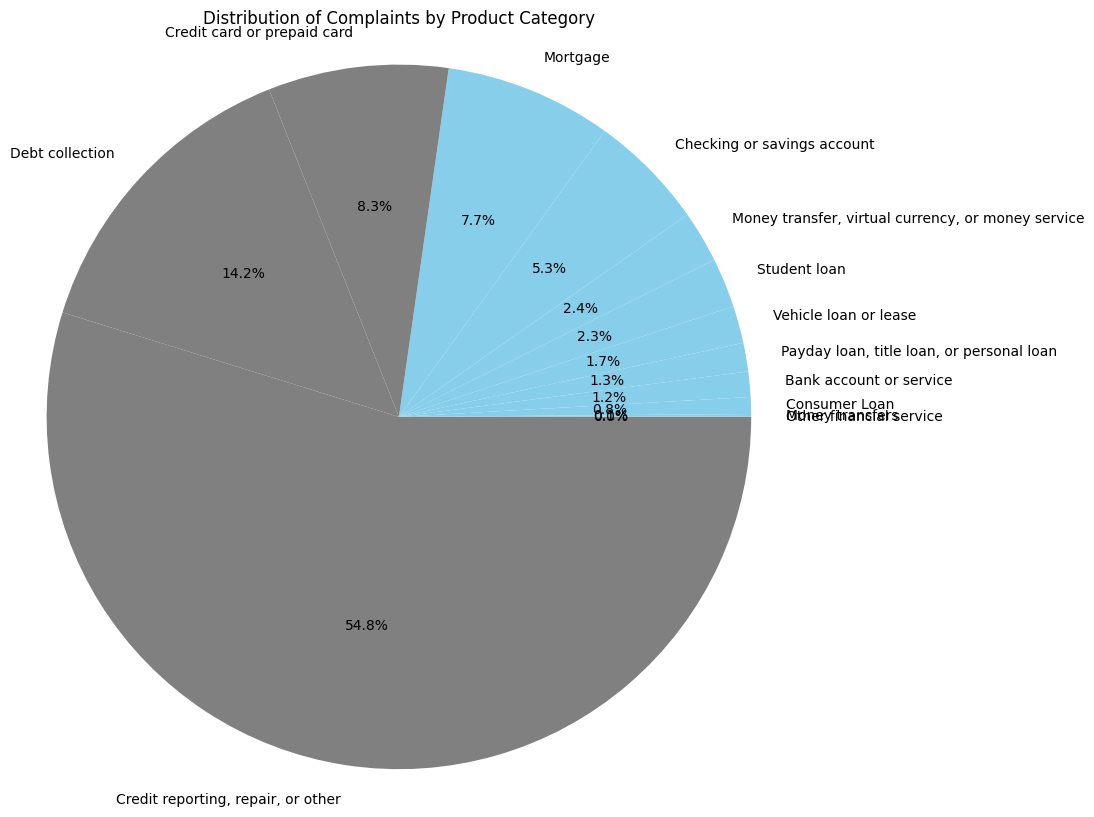

In [14]:
# Group and sort the data
product_counts = df2.groupby('Product').Consumer_complaint.count().sort_values()

# Customizing the color palette
colors = ['skyblue'] * 10 + ['gray'] * 3

# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(product_counts, labels=product_counts.index, colors=colors, autopct='%1.1f%%')
plt.title('Distribution of Complaints by Product Category', fontsize=12)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


The code uses the TF-IDF vectorization technique to convert text complaints into numerical vectors for analysis. It filters out rare words, considers both single words and pairs of words, removes common English stop words, and assigns labels to the complaints. The resulting TF-IDF matrix can be used for machine learning tasks.

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26367 features (TF-IDF score of unigrams and bigrams)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

# Your TF-IDF vectorization code (initialize tfidf and compute features) goes here

N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())
    unigrams = [feature_names[i] for i in indices[-N:]]
    bigrams = [feature_names[i] for i in indices[-2 * N:-N]]  # Adjusted for bigrams

    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams)))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams)))



==> Bank account or service:
  * Most Correlated Unigrams are: bbt, insufficient funds, citigold
  * Most Correlated Bigrams are: atm, initial deposit, overdraft

==> Checking or savings account:
  * Most Correlated Unigrams are: checking account, deposit, bank
  * Most Correlated Bigrams are: deposited, checking, branch

==> Consumer Loan:
  * Most Correlated Unigrams are: vehicle, toyota, car worth
  * Most Correlated Bigrams are: payoff xxxx, ford, car

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: american express, credit card, card
  * Most Correlated Bigrams are: citi, express, capital

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, section, reporting
  * Most Correlated Bigrams are: 1681 section, 1681, bank

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: collector, owe, collect debt

==> Money transfer, virtual currency, or money service:
  * Most Correlate

Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [17]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state = 0)

Below provided code performs 5-fold cross-validation for four different classification models (RandomForestClassifier, LinearSVC, MultinomialNB, and LogisticRegression) on a dataset with features (`features`) and labels (`labels`). It then stores the results in a DataFrame called `cv_df`. Here's a summary of what the code does:

1. **Model Initialization:**
   - Four classification models are initialized: RandomForestClassifier, LinearSVC, MultinomialNB, and LogisticRegression. Each model has specific parameters like `n_estimators`, `max_depth`, and `random_state` for RandomForestClassifier and `random_state` for LogisticRegression.

2. **Cross-Validation Setup:**
   - The code sets the number of cross-validation folds (`CV`) to 5. This means the dataset will be split into 5 subsets, and the models will be trained and tested five times, with a different subset as the test set in each iteration.

3. **Cross-Validation Loop:**
   - The code iterates through each model and performs 5-fold cross-validation.
   - For each fold, it records the model's name, fold index, and the accuracy score.

4. **DataFrame Creation:**
   - The results from each fold are collected into a list of entries.
   - A DataFrame called `cv_df` is created using the collected entries, with columns: 'model_name', 'fold_idx', and 'accuracy'. This DataFrame summarizes the model's performance in each fold.

In summary, this code is used to compare the performance of four different classification models using 5-fold cross-validation and stores the results in a DataFrame for further analysis or reporting.

In [18]:
from sklearn.model_selection import cross_val_score
import pandas as pd

# Define the models and their parameters in a list of tuples
models = [
    (RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0), 'RandomForest'),
    (LinearSVC(), 'LinearSVC'),
    (MultinomialNB(), 'MultinomialNB'),
    (LogisticRegression(random_state=0), 'LogisticRegression')
]

# Number of Cross-validation folds
CV = 8

# Create a DataFrame to store the results
cv_df = pd.DataFrame()

# Iterate through the models and perform cross-validation
for model, model_name in models:
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    model_entries = pd.DataFrame({'Model': [model_name] * CV, 'Fold Index': range(CV), 'Accuracy': accuracies})
    cv_df = cv_df.append(model_entries, ignore_index=True)

# Optionally, you can sort the DataFrame by model name and fold index
cv_df.sort_values(by=['Model', 'Fold Index'], inplace=True)

# Reset the index for the DataFrame for better presentation
cv_df.reset_index(drop=True, inplace=True)

# Print the DataFrame with the cross-validation results
print(cv_df)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale 

                 Model  Fold Index  Accuracy
0            LinearSVC           0    0.8384
1            LinearSVC           1    0.8248
2            LinearSVC           2    0.8432
3            LinearSVC           3    0.8424
4            LinearSVC           4    0.8080
5            LinearSVC           5    0.8208
6            LinearSVC           6    0.8432
7            LinearSVC           7    0.8440
8   LogisticRegression           0    0.8080
9   LogisticRegression           1    0.8016
10  LogisticRegression           2    0.8200
11  LogisticRegression           3    0.8288
12  LogisticRegression           4    0.7904
13  LogisticRegression           5    0.8152
14  LogisticRegression           6    0.8240
15  LogisticRegression           7    0.8200
16       MultinomialNB           0    0.7024
17       MultinomialNB           1    0.7008
18       MultinomialNB           2    0.7016
19       MultinomialNB           3    0.7080
20       MultinomialNB           4    0.6960
21       M

In [19]:
print(cv_df)

                 Model  Fold Index  Accuracy
0            LinearSVC           0    0.8384
1            LinearSVC           1    0.8248
2            LinearSVC           2    0.8432
3            LinearSVC           3    0.8424
4            LinearSVC           4    0.8080
5            LinearSVC           5    0.8208
6            LinearSVC           6    0.8432
7            LinearSVC           7    0.8440
8   LogisticRegression           0    0.8080
9   LogisticRegression           1    0.8016
10  LogisticRegression           2    0.8200
11  LogisticRegression           3    0.8288
12  LogisticRegression           4    0.7904
13  LogisticRegression           5    0.8152
14  LogisticRegression           6    0.8240
15  LogisticRegression           7    0.8200
16       MultinomialNB           0    0.7024
17       MultinomialNB           1    0.7008
18       MultinomialNB           2    0.7016
19       MultinomialNB           3    0.7080
20       MultinomialNB           4    0.6960
21       M

The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [20]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state = 0)

## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [21]:
mean_accuracy = cv_df.groupby('Model').Accuracy.mean()
std_accuracy = cv_df.groupby('Model').Accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
Model,,
LinearSVC,0.8331,0.013563
LogisticRegression,0.8135,0.012746
MultinomialNB,0.7029,0.004484
RandomForest,0.5484,0.000605


In [22]:
# Assuming you have already calculated 'acc' as described in your code

# Print the mean accuracy and standard deviation for each model
for index, row in acc.iterrows():
    model_name = index
    mean_accuracy = row['Mean Accuracy']
    std_deviation = row['Standard deviation']

    print(f"Model: {model_name}")
    print(f"Mean Accuracy: {mean_accuracy}")
    print(f"Standard Deviation: {std_deviation}\n")


Model: LinearSVC
Mean Accuracy: 0.8331
Standard Deviation: 0.013562553489032098

Model: LogisticRegression
Mean Accuracy: 0.8135
Standard Deviation: 0.01274586767768845

Model: MultinomialNB
Mean Accuracy: 0.7029
Standard Deviation: 0.004483620985638402

Model: RandomForest
Mean Accuracy: 0.5484
Standard Deviation: 0.0006047431568147377



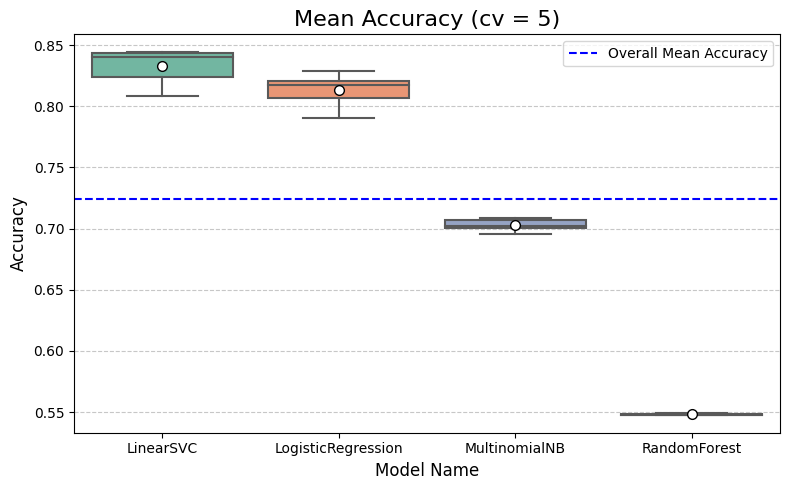

In [23]:
plt.figure(figsize=(8, 5))  # Adjust the figure size

# Customize the color palette for the box plot
palette = sns.color_palette("Set2")

# Create the box plot with improved aesthetics
sns.boxplot(x='Model', y='Accuracy',
            data=cv_df,
            palette=palette,  # Use the custom color palette
            showmeans=True,
            meanprops={'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'white', 'markersize':7})

# Add a title and labels
plt.title("Mean Accuracy (cv = 5)", size=16)
plt.xlabel("Model Name", size=12)
plt.ylabel("Accuracy", size=12)

# Rotate x-axis labels for better readability if needed
# plt.xticks(rotation=45)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line for the mean of all models
overall_mean_accuracy = cv_df['Accuracy'].mean()
plt.axhline(y=overall_mean_accuracy, color='blue', linestyle='--', label='Overall Mean Accuracy')

# Add legend for the overall mean accuracy line
plt.legend(loc='upper right')

# Show plot
plt.tight_layout()  # Ensures labels are not cut off
plt.show()


####Model Evaluation

In [24]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

###Precision, Recall, F1-score

In [25]:
# Classification report
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred))


				CLASSIFICATION METRICS

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       240
           1       0.88      0.95      0.92      1356
           2       0.86      0.89      0.87       191
           3       0.89      0.62      0.73        63
           4       0.79      0.71      0.75       351
           5       0.48      0.35      0.41        43
           6       0.66      0.77      0.71       128
           7       0.75      0.21      0.32        29
           8       0.84      0.81      0.83        53
           9       0.50      0.04      0.07        27
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         1

    accuracy                           0.84      2500
   macro avg       0.62      0.51      0.53      2500
weighted avg       0.82      0.84      0.82      2500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

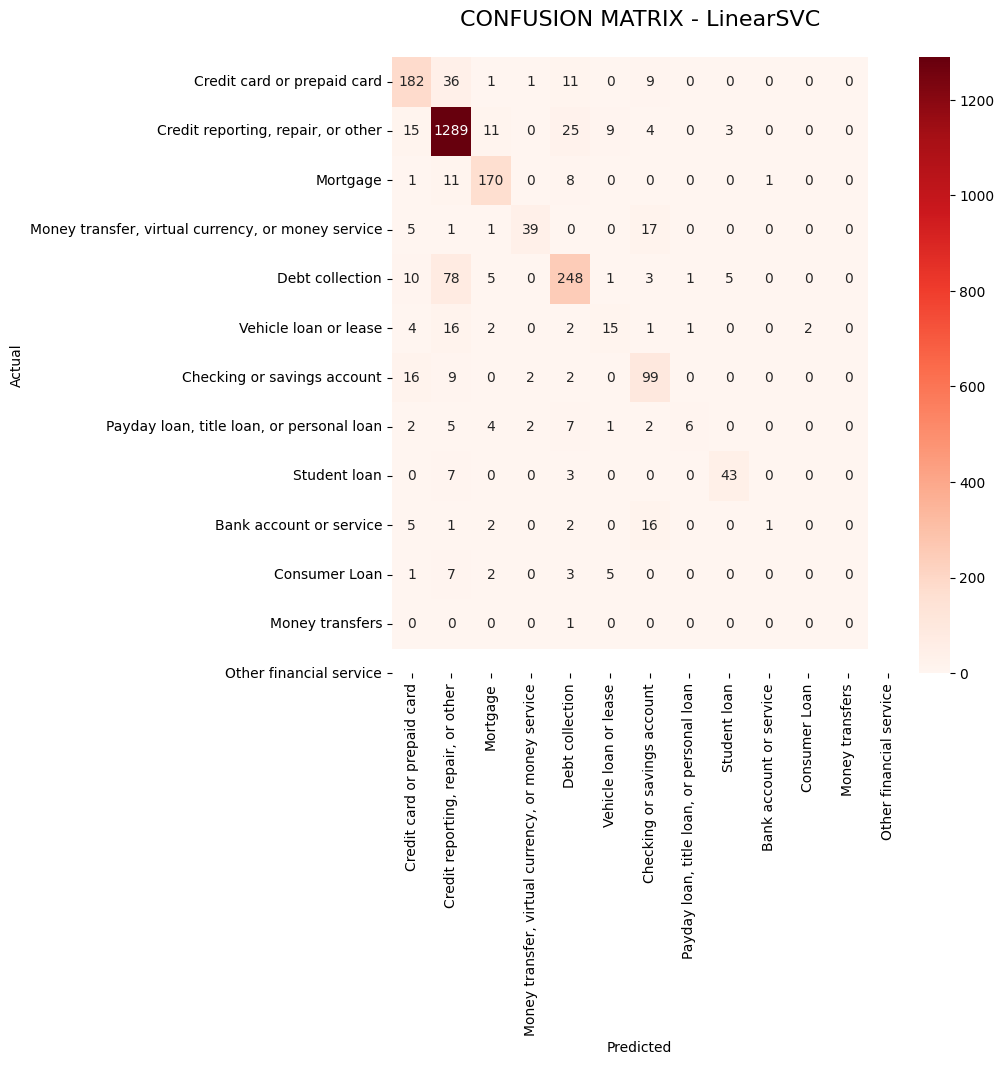

In [26]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [27]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual-1, predicted-1] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Consumer_complaint']])
      print('')

'Credit reporting, repair, or other' predicted as 'Mortgage' : 11 examples.


,Product,Consumer_complaint
3847111,"Credit reporting, repair, or other","Good evening, To whom it may concern, I paid X..."
328022,"Credit reporting, repair, or other",On XX/XX/2020 and during the COVID period I ha...
3582176,"Credit reporting, repair, or other",I have been in the foreclosure process in New ...
1432010,"Credit reporting, repair, or other",XXXX XXXX refuses to mark our XXXX mortgage pa...
1297216,"Credit reporting, repair, or other",Company still refuses my request to discontinu...
1510144,"Credit reporting, repair, or other",XXXX AND EXPERIAN ARE FALSING REPORT OLD MORTA...
2270038,"Credit reporting, repair, or other",XXXX acct # XXXX : Did not inform me ASAP abou...
303938,"Credit reporting, repair, or other",We filed bankruptcy in 2015 but never foreclos...
999115,"Credit reporting, repair, or other",Specialized Loan Servicing currently reports a...
461038,"Credit reporting, repair, or other","This is notice to XXXX, XXXX and Equifax, that..."



'Vehicle loan or lease' predicted as 'Mortgage' : 2 examples.


,Product,Consumer_complaint
965584,Vehicle loan or lease,I currently have a marine/boat loan with 53 ba...
2308338,Vehicle loan or lease,"I made a monthly Payment of principal, interes..."



'Mortgage' predicted as 'Vehicle loan or lease' : 0 examples.


,Product,Consumer_complaint


#### Most correlated terms with each category

In [28]:
model.fit(features, labels)
N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf. get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))



==> 'Bank account or service':
  * Top unigrams: bank, payroll, citigold, banks
  * Top bigrams: business account, insufficient funds, xxxx 2015, initial deposit

==> 'Checking or savings account':
  * Top unigrams: bank, atm, check, branch
  * Top bigrams: savings account, new checking, account info, access money

==> 'Consumer Loan':
  * Top unigrams: ford, toyota, loan, vehicle
  * Top bigrams: hit credit, car xxxx, car worth, 16 xxxx

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, barclays, express
  * Top bigrams: credit card, american express, xxxx inquiries, need remove

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, report
  * Top bigrams: xxxx xxxx, incorrect information, trans union, xxxx bank

==> 'Debt collection':
  * Top unigrams: debt, collection, collections, collect
  * Top bigrams: credit collection, service xxxx, stop calling, time payment

==> 'Money transfer, virtual currency, or money service':
  * 

## Predictions

Now let's make a few predictions on unseen data.<br>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's see what is the classification that our model gives to this new complaint.

Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [36]:
new_complaint = """I am deeply frustrated with my vehicle loan from SBI Bank .
Despite timely payments, they continue to harass me for outstanding amounts and have reported inaccurate late payments to credit agencies.
 This jeopardizes my credit score and financial stability.
 I urgently request resolution to this issue to ensure accurate reporting and protect my financial standing."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Credit reporting, repair, or other']


In [30]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [32]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [34]:
new_complaint = """I've encountered a problem with a recent bank money transfer. Please investigate and resolve it promptly."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Money transfer, virtual currency, or money service']


In [38]:
new_complaint = """I am writing to express my deep concern and dissatisfaction with the debt collection practices employed by Agency.
I believe that my rights under the Fair Debt Collection Practices Act (FDCPA) are being violated,
and I would like to formally register a complaint regarding the handling of my debt collection."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Debt collection']


In [39]:
new_complaint = """I am writing to formally register a complaint regarding ongoing issues and concerns related to my mortgage account with Company.
I believe that my experiences have been unsatisfactory and necessitate immediate attention and resolution."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Mortgage']
